In [17]:
import pygame
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Actions
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]
ACTION_NAMES = ['UP', 'DOWN', 'LEFT', 'RIGHT']

COLOR_BG = (30, 30, 30)
COLOR_WALL = (100, 100, 100)
COLOR_HARRY = (0, 255, 0)       
COLOR_DEATH = (255, 0, 0)       
COLOR_CUP = (255, 215, 0)       
CELL_SIZE = 40  

def load_maze(filename):
    with open(filename, 'r') as f:
        lines = [line.strip('\n') for line in f.readlines()]
    grid = []
    for line in lines:
        row = []
        for ch in line:
            if ch == 'X':
                row.append(1)  # wall
            else:
                row.append(0)  # free space
        grid.append(row)
    return np.array(grid)


class HarryMazeEnv:
    def __init__(self, maze_file, render=True):
        self.grid = load_maze(maze_file)
        self.rows, self.cols = self.grid.shape
        self.render = render
        if self.render:
            pygame.init()
            self.screen = pygame.display.set_mode((self.cols * CELL_SIZE, self.rows * CELL_SIZE))
            pygame.display.set_caption("Harry's Maze - Triwizard Tournament")
            self.clock = pygame.time.Clock()

        self.reset()
        self.action_space = len(ACTIONS)
    # state represented as tuple ((harry_r, harry_c), (death_r, death_c), (cup_r, cup_c))

    def reset(self):
        # Place Harry, Death Eater, and Cup randomly on free cells, no overlaps
        free_cells = list(zip(*np.where(self.grid == 0)))
        self.harry_pos = random.choice(free_cells)
        free_cells.remove(self.harry_pos)
        self.death_pos = random.choice(free_cells)
        free_cells.remove(self.death_pos)
        self.cup_pos = random.choice(free_cells)
        self.done = False
        self.steps = 0
        return self._get_state()

    def _get_state(self):
        return (self.harry_pos, self.death_pos, self.cup_pos)

    def _is_valid(self, pos):
        r, c = pos
        if r < 0 or r >= self.rows or c < 0 or c >= self.cols:
            return False
        if self.grid[r, c] == 1:
            return False
        return True

    def _move(self, pos, action):
        r, c = pos
        if action == UP:
            r -= 1
        elif action == DOWN:
            r += 1
        elif action == LEFT:
            c -= 1
        elif action == RIGHT:
            c += 1
        if self._is_valid((r, c)):
            return (r, c)
        return pos  

    def _bfs_path(self, start, goal):
        # BFS to find path from start to goal, return first step toward goal or None if no path
        queue = deque()
        queue.append(start)
        visited = set()
        visited.add(start)
        parent = {start: None}

        while queue:
            current = queue.popleft()
            if current == goal:
                # backtrack path
                path = []
                while current != start:
                    path.append(current)
                    current = parent[current]
                path.reverse()
                return path
            for action in ACTIONS:
                nr, nc = current
                if action == UP:
                    nr -= 1
                elif action == DOWN:
                    nr += 1
                elif action == LEFT:
                    nc -= 1
                elif action == RIGHT:
                    nc += 1
                neighbor = (nr, nc)
                if self._is_valid(neighbor) and neighbor not in visited:
                    visited.add(neighbor)
                    parent[neighbor] = current
                    queue.append(neighbor)
        return None

    def step(self, action):
        if self.done:
            raise Exception("Episode done. Call reset() to start new episode.")

        self.steps += 1

        # move harry
        new_harry_pos = self._move(self.harry_pos, action)

        # move death eater towards harry via BFS
        path = self._bfs_path(self.death_pos, new_harry_pos)
        if path and len(path) > 0:
            new_death_pos = path[0]
        else:
            new_death_pos = self.death_pos  # no move if no path

        self.harry_pos = new_harry_pos
        self.death_pos = new_death_pos

        reward = -1  # step penalty
        self.done = False
        info = {}

        if self.harry_pos == self.cup_pos:
            reward = 100
            self.done = True
            info['outcome'] = 'cup_reached'

        elif self.harry_pos == self.death_pos:
            reward = -100
            self.done = True
            info['outcome'] = 'caught'

        return self._get_state(), reward, self.done, info

    def render_env(self):
        if not self.render:
            return
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                exit()

        self.screen.fill(COLOR_BG)
        # Draw walls
        for r in range(self.rows):
            for c in range(self.cols):
                if self.grid[r, c] == 1:
                    pygame.draw.rect(self.screen, COLOR_WALL,
                                     (c * CELL_SIZE, r * CELL_SIZE, CELL_SIZE, CELL_SIZE))

        # Draw Cup
        cr, cc = self.cup_pos
        pygame.draw.rect(self.screen, COLOR_CUP,
                         (cc * CELL_SIZE + 5, cr * CELL_SIZE + 5, CELL_SIZE - 10, CELL_SIZE - 10))

        # Draw Death Eater
        dr, dc = self.death_pos
        pygame.draw.rect(self.screen, COLOR_DEATH,
                         (dc * CELL_SIZE + 5, dr * CELL_SIZE + 5, CELL_SIZE - 10, CELL_SIZE - 10))

        # Draw Harry
        hr, hc = self.harry_pos
        pygame.draw.rect(self.screen, COLOR_HARRY,
                         (hc * CELL_SIZE + 5, hr * CELL_SIZE + 5, CELL_SIZE - 10, CELL_SIZE - 10))

        pygame.display.flip()
        self.clock.tick(10)  




In [18]:
# Q-learning agent
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha          # learning rate
        self.gamma = gamma          # discount factor
        self.epsilon = epsilon      # exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = {}

    def get_state_key(self, state):
        # state is ((hr,hc),(dr,dc),(cr,cc)) tuple, use as key
        return state

    def choose_action(self, state):
        key = self.get_state_key(state)
        if random.random() < self.epsilon or key not in self.q_table:
            return random.choice(ACTIONS)
        else:
            return max(self.q_table[key], key=self.q_table[key].get)

    def learn(self, state, action, reward, next_state, done):
        key = self.get_state_key(state)
        next_key = self.get_state_key(next_state)

        if key not in self.q_table:
            self.q_table[key] = {a: 0 for a in ACTIONS}
        if next_key not in self.q_table:
            self.q_table[next_key] = {a: 0 for a in ACTIONS}

        q_predict = self.q_table[key][action]
        if done:
            q_target = reward
        else:
            q_target = reward + self.gamma * max(self.q_table[next_key].values())

        self.q_table[key][action] += self.alpha * (q_target - q_predict)

        # Decay epsilon
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [19]:
import pickle
def save_q_table(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

In [20]:
def train(env, agent, episodes=5000, render_every=100):
    rewards = []
    success_count = 0
    success_rates = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if env.render and (ep % render_every == 0):
                env.render_env()

            action = agent.choose_action(state)
            next_state, reward, done, info = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

        rewards.append(total_reward)
        if 'outcome' in info and info['outcome'] == 'cup_reached':
            success_count += 1

        if (ep + 1) % 100 == 0:
            success_rate = success_count / 100
            print(f"Episode {ep+1} Reward: {total_reward}, Success Rate last 100: {success_rate:.2f}, Epsilon: {agent.epsilon:.3f}")
            success_rates.append(success_rate)
            success_count = 0
    save_q_table(agent,"qtable.pkl")
   
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rewards)
    plt.title("Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(1,2,2)
    plt.plot(success_rates)
    plt.title("Success Rate per 100 Episodes")
    plt.xlabel("Episode (x100)")
    plt.ylabel("Success Rate")
    plt.show()

In [21]:
def test_agent(env, q_table, episodes=100, render=False, show_best=True, max_steps=200):
    success_count = 0
    rewards_list = []
    all_trajectories = []

    for ep in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        trajectory = []
        step_count = 0

        while not done and step_count < max_steps:
            q_values = q_table.get(state, {a: 0 for a in ACTIONS})
            action = max(q_values, key=q_values.get)
            trajectory.append((state, action))

            next_state, reward, done, info = env.step(action)
            total_reward += reward
            state = next_state
            step_count += 1

            if render:
                env.render_env()

        rewards_list.append(total_reward)
        all_trajectories.append((total_reward, trajectory))

        if 'outcome' in info and info['outcome'] == 'cup_reached':
            success_count += 1

        print(f"Episode {ep + 1} | Reward: {total_reward} | Outcome: {info.get('outcome', 'unknown')}")

    success_rate = success_count / episodes
    avg_reward = sum(rewards_list) / episodes
    print(f"\nTest results over {episodes} episodes:")
    print(f"Success Rate = {success_rate:.2f}")
    print(f"Average Reward = {avg_reward:.2f}")

    return success_rate, avg_reward

Episode 100 Reward: -110, Success Rate last 100: 0.04, Epsilon: 0.606
Episode 200 Reward: -106, Success Rate last 100: 0.04, Epsilon: 0.367
Episode 300 Reward: -104, Success Rate last 100: 0.05, Epsilon: 0.222
Episode 400 Reward: -116, Success Rate last 100: 0.01, Epsilon: 0.135
Episode 500 Reward: -105, Success Rate last 100: 0.05, Epsilon: 0.082
Episode 600 Reward: -108, Success Rate last 100: 0.04, Epsilon: 0.049
Episode 700 Reward: -102, Success Rate last 100: 0.05, Epsilon: 0.030
Episode 800 Reward: -108, Success Rate last 100: 0.01, Epsilon: 0.018
Episode 900 Reward: -115, Success Rate last 100: 0.03, Epsilon: 0.011
Episode 1000 Reward: -102, Success Rate last 100: 0.03, Epsilon: 0.010
Episode 1100 Reward: -104, Success Rate last 100: 0.01, Epsilon: 0.010
Episode 1200 Reward: -102, Success Rate last 100: 0.02, Epsilon: 0.010
Episode 1300 Reward: -100, Success Rate last 100: 0.02, Epsilon: 0.010
Episode 1400 Reward: -104, Success Rate last 100: 0.05, Epsilon: 0.010
Episode 1500 Re

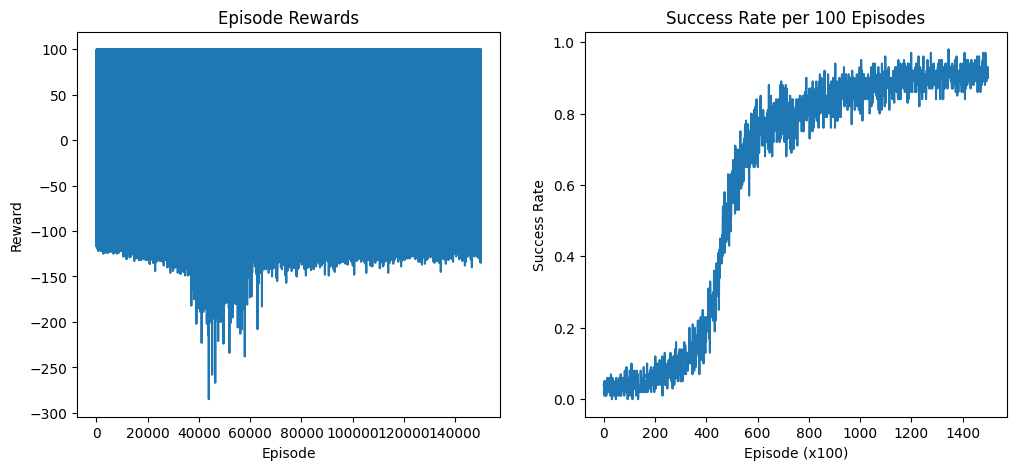

Episode 1 | Reward: 91 | Outcome: cup_reached
Episode 2 | Reward: 75 | Outcome: cup_reached
Episode 3 | Reward: 95 | Outcome: cup_reached
Episode 4 | Reward: 76 | Outcome: cup_reached
Episode 5 | Reward: 81 | Outcome: cup_reached
Episode 6 | Reward: 92 | Outcome: cup_reached
Episode 7 | Reward: -300 | Outcome: unknown
Episode 8 | Reward: 90 | Outcome: cup_reached
Episode 9 | Reward: -106 | Outcome: caught
Episode 10 | Reward: 75 | Outcome: cup_reached
Episode 11 | Reward: 99 | Outcome: cup_reached
Episode 12 | Reward: 85 | Outcome: cup_reached
Episode 13 | Reward: -117 | Outcome: caught
Episode 14 | Reward: 86 | Outcome: cup_reached
Episode 15 | Reward: 89 | Outcome: cup_reached
Episode 16 | Reward: 99 | Outcome: cup_reached
Episode 17 | Reward: 78 | Outcome: cup_reached
Episode 18 | Reward: 80 | Outcome: cup_reached
Episode 19 | Reward: 83 | Outcome: cup_reached
Episode 20 | Reward: -300 | Outcome: unknown
Episode 21 | Reward: 85 | Outcome: cup_reached
Episode 22 | Reward: 85 | Outcom

In [22]:
if __name__ == "__main__":
    maze_file = 'maze2.txt'  
    env = HarryMazeEnv(maze_file, render=False)
    agent = QLearningAgent(env)
    train(env, agent, episodes=150000, render_every=10000)
    test_agent(env, agent.q_table, episodes=100, render=False, show_best=True, max_steps=300)

In [23]:
def generations_to_consistent_escape(env, q_table, max_generations=10000, render=False):
    consecutive_successes = 0
    total_generations = 0

    while total_generations < max_generations:
        total_generations += 1
        state = env.reset()
        done = False
        steps = 0
        max_steps = 300

        while not done and steps < max_steps:
            q_values = q_table.get(state, {a: 0 for a in ACTIONS})
            action = max(q_values, key=q_values.get)
            next_state, reward, done, info = env.step(action)
            state = next_state
            steps += 1

            if render:
                env.render_env()

        if info.get('outcome') == 'cup_reached':
            consecutive_successes += 1
        else:
            consecutive_successes = 0

        print(f"Generation {total_generations}: Outcome = {info.get('outcome', 'unknown')} | Consecutive Escapes = {consecutive_successes}")

        if consecutive_successes >= 10:
            print(f"\nHarry consistently escaped 10 times in a row after {total_generations} generations.")
            return total_generations

    print(f"\nDid not achieve 10 consecutive escapes within {max_generations} generations.")
    return total_generations
generations_to_consistent_escape(env, agent.q_table, render=False)


Generation 1: Outcome = cup_reached | Consecutive Escapes = 1
Generation 2: Outcome = cup_reached | Consecutive Escapes = 2
Generation 3: Outcome = cup_reached | Consecutive Escapes = 3
Generation 4: Outcome = cup_reached | Consecutive Escapes = 4
Generation 5: Outcome = cup_reached | Consecutive Escapes = 5
Generation 6: Outcome = cup_reached | Consecutive Escapes = 6
Generation 7: Outcome = cup_reached | Consecutive Escapes = 7
Generation 8: Outcome = cup_reached | Consecutive Escapes = 8
Generation 9: Outcome = cup_reached | Consecutive Escapes = 9
Generation 10: Outcome = cup_reached | Consecutive Escapes = 10

Harry consistently escaped 10 times in a row after 10 generations.


10